In [24]:
import requests
import sqlite3
from datetime import datetime, timedelta, date

# Configuración de la conexión a la base de datos SQLite
conn = sqlite3.connect('tokens.db')
c = conn.cursor()

# Método para obtener el access_token y refresh_token de la base de datos
def get_tokens():
    c.execute("SELECT * FROM tokens")
    tokens = c.fetchone()
    if tokens is None:
        return None
    access_token, refresh_token, expiration_date = tokens
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d %H:%M:%S')
    return access_token, refresh_token, expiration_date

# Método para guardar el access_token y refresh_token en la base de datos
def save_tokens(access_token, refresh_token, expiration_date):
    c.execute("DELETE FROM tokens")
    c.execute("INSERT INTO tokens VALUES (?, ?, ?)",
            (access_token, refresh_token, expiration_date))
    conn.commit()

# Método para obtener un nuevo access_token y refresh_token
def get_new_tokens(refresh_token):
    url = "https://api.mercadolibre.com/oauth/token"
    payload = {
        "grant_type": "refresh_token",
        "client_id": "5030313997317379",
        "client_secret": "zTJax3dLAiog35gQdaOVEhTSwxXxbTTY",
        "refresh_token": refresh_token
    }
    response = requests.post(url, data=payload)
    response.raise_for_status()
    data = response.json()
    access_token = data['access_token']
    refresh_token = data['refresh_token']
    expires_in = data['expires_in']
    expiration_date = datetime.now() + timedelta(seconds=expires_in)
    expiration_date_str = expiration_date.strftime('%Y-%m-%d %H:%M:%S')
    save_tokens(access_token, refresh_token, expiration_date_str)
    return access_token, refresh_token, expiration_date_str

# Método para hacer la petición con el access_token
def make_request(access_token, url):
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()
    return data

# Método para hacer una petición a la main
def do_request(url, params=None):
    tokens = get_tokens()
    if tokens is None or tokens[2] < datetime.now():
        refresh_token = tokens[1] if tokens is not None else input("Ingrese refresh_token: ")
        access_token, refresh_token, expiration_date = get_new_tokens(refresh_token)
    else:
        access_token, refresh_token, expiration_date = tokens
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    
    return data

# Método para obtener las visitas de cada producto
def get_product_visits(product_id):
    today = date.today()
    last_month = today - timedelta(days=30)
    
    endpoint = f"https://api.mercadolibre.com/visits/items"
    params = {
        "ids": product_id,
        "date_from": last_month.isoformat(),
        "date_to": today.isoformat()
    }

    # Aquí se utiliza la función do_request para realizar la solicitud con el access token
    response = do_request(endpoint, params=params)
    if response and isinstance(response, dict):
        product_visits = response.get(product_id)
        return product_visits
    
    return None



url = "https://api.mercadolibre.com/trends/MLC"
url2 = "https://api.mercadolibre.com/sites/MLC/search?category=MLC82067"
url3 = "https://api.mercadolibre.com/sites/MLC/search?category=MLC1648&offset=50"
url4 = "https://api.mercadolibre.com/sites/MLC/search?category=MLC1648&offset=100"
url5 = "https://api.mercadolibre.com/highlights/$SITE_ID/category/$CATEGORY_ID"

# datos json
datos_json = do_request(url2)['results']

In [2]:
import pandas as pd
import json
datos_filtrados = []

for producto in datos_json:
    producto_filtrado = {
        "id": producto["id"],
        "title": producto["title"],
        "condition": producto["condition"],
        "thumbnail_id": producto["thumbnail_id"],
        "listing_type_id": producto["listing_type_id"],
        "permalink": producto["permalink"],
        "sold_quantity": producto["sold_quantity"],
        "available_quantity": producto["available_quantity"],
        "price": producto["price"],
    }
    datos_filtrados.append(producto_filtrado)
    
df = pd.DataFrame(datos_filtrados)
df.head(50)

,id,title,condition,thumbnail_id,listing_type_id,permalink,sold_quantity,available_quantity,price
0,MLC933990141,Apple iPad (9ª Generación) 10.2 Wi-fi 64gb - ...,new,907886-MLU69497668167_052023,gold_pro,https://www.mercadolibre.cl/apple-ipad-9-gener...,500,500,309990
1,MLC943586833,Apple iPad (9ª Generación) 10.2 Wi-fi 256gb -...,new,706956-MLU69486027564_052023,gold_pro,https://www.mercadolibre.cl/apple-ipad-9-gener...,250,100,469990
2,MLC943599729,Apple iPad (9ª Generación) 10.2 Wi-fi 256gb -...,new,898922-MLU69482631414_052023,gold_pro,https://www.mercadolibre.cl/apple-ipad-9-gener...,250,150,469990
3,MLC1267266672,Apple iPad (9ª Generación) 10.2 Wi-fi 64gb - ...,new,625786-MLU69484160938_052023,gold_special,https://www.mercadolibre.cl/apple-ipad-9-gener...,2,1,344990
4,MLC1608885778,Tablet Mlab Kids Play & Learn Se 16gb Rom 2gb ...,new,601122-MLC52446236804_112022,gold_special,https://www.mercadolibre.cl/tablet-mlab-kids-p...,5,1,62300
5,MLC1234505308,Tablet Samsung Galaxy Tab A A7 Lite Sm-t225 8...,new,667801-MLA47848605440_102021,gold_special,https://www.mercadolibre.cl/tablet-samsung-gal...,150,50,131990
6,MLC1691643942,Tablet Lenovo Tab M10 Hd 2nd Gen With Folio C...,new,795476-MLA48642456248_122021,gold_special,https://www.mercadolibre.cl/tablet-lenovo-tab-...,50,1,169990
7,MLC958421903,Tablet Samsung Galaxy Tab A A7 Lite Sm-t220 8...,new,752514-MLA47146849081_082021,gold_special,https://www.mercadolibre.cl/tablet-samsung-gal...,500,1,169990
8,MLC1012514042,Tablet Con Funda Mlab Glowy 8990 Sketch Pen 1...,new,773627-MLA48644452913_122021,gold_special,https://www.mercadolibre.cl/tablet-con-funda-m...,150,1,101002
9,MLC1283492787,Tablet Lenovo Tab M10 Fhd Plus 2nd Gen Tb-x60...,new,859394-MLA45630184289_042021,gold_special,https://www.mercadolibre.cl/tablet-lenovo-tab-...,25,1,189990


In [3]:
import timeit
total_resultados = 4000
resultados_por_pagina = 50
paginas = total_resultados // resultados_por_pagina  # Calcula el número total de páginas

datos_filtrados_full = []

for pagina in range(1, paginas + 1):
    parametros = {
        "offset": (pagina - 1) * resultados_por_pagina,
        "limit": resultados_por_pagina
    }
    respuesta = do_request(url2, parametros)
    if "results" in respuesta and respuesta["results"]:
        datos_pagina = respuesta["results"]
        for producto in datos_pagina:
            producto_filtrado = {
                "id": producto["id"],
                "title": producto["title"],
                "condition": producto["condition"],
                "price": producto["price"],
                "permalink": producto["permalink"],
                "thumbnail": producto["thumbnail"],
                "sold_quantity": producto["sold_quantity"],
                "available_quantity": producto["available_quantity"],
                "brand": None,
                "model": None,
                "shipping": producto["shipping"]["free_shipping"],
            }
            for atributo in producto["attributes"]:
                if atributo["id"] == "BRAND":
                    producto_filtrado["brand"] = atributo["value_name"]
                elif atributo["id"] == "MODEL":
                    producto_filtrado["model"] = atributo["value_name"]
                    
            datos_filtrados_full.append(producto_filtrado)
                    
tablets = pd.DataFrame(datos_filtrados_full)
execution_time = timeit.timeit(my_code, number=1)
print(f"Tiempo de ejecución: {execution_time} segundos")

In [35]:
%%time

def my_code(total_resultados):
    resultados_por_pagina = 50
    paginas = total_resultados // resultados_por_pagina

    datos_filtrados_full = []

    for pagina in range(1, paginas + 1):
        parametros = {
            "offset": (pagina - 1) * resultados_por_pagina,
            "limit": resultados_por_pagina
        }
        respuesta = do_request(url2, parametros)
        if "results" in respuesta and respuesta["results"]:
            datos_pagina = respuesta["results"]
            for producto in datos_pagina:
                producto_filtrado = {
                    "id": producto["id"],
                    "title": producto["title"],
                    "condition": producto["condition"],
                    "price": producto["price"],
                    "permalink": producto["permalink"],
                    "thumbnail": producto["thumbnail"],
                    "sold_quantity": producto["sold_quantity"],
                    "available_quantity": producto["available_quantity"],
                    "brand": None,
                    "model": None,
                    "shipping": producto["shipping"]["free_shipping"],
                    "visits_last_month": get_product_visits(producto["id"])
                }
                for atributo in producto["attributes"]:
                    if atributo["id"] == "BRAND":
                        producto_filtrado["brand"] = atributo["value_name"]
                    elif atributo["id"] == "MODEL":
                        producto_filtrado["model"] = atributo["value_name"]

                datos_filtrados_full.append(producto_filtrado)

    tablets = pd.DataFrame(datos_filtrados_full)

    return tablets


# Define el número total de resultados
total_resultados = 4000

# Ejecuta la función y obtiene los datos filtrados
tablets = my_code(total_resultados)

CPU times: total: 53.1 s
Wall time: 19min 7s


In [27]:
tablets.head()

,id,title,condition,price,permalink,thumbnail,sold_quantity,available_quantity,brand,model,shipping,visits_last_month
0,MLC933990141,Apple iPad (9ª Generación) 10.2 Wi-fi 64gb - ...,new,309990,https://www.mercadolibre.cl/apple-ipad-9-gener...,http://http2.mlstatic.com/D_907886-MLU69497668...,500,500,Apple,9th generation,True,37555
1,MLC1267266672,Apple iPad (9ª Generación) 10.2 Wi-fi 64gb - ...,new,344990,https://www.mercadolibre.cl/apple-ipad-9-gener...,http://http2.mlstatic.com/D_625786-MLU69484160...,2,1,Apple,9th generation,True,398
2,MLC943586833,Apple iPad (9ª Generación) 10.2 Wi-fi 256gb -...,new,469990,https://www.mercadolibre.cl/apple-ipad-9-gener...,http://http2.mlstatic.com/D_706956-MLU69486027...,250,100,Apple,9th generation,True,20099
3,MLC1608885778,Tablet Mlab Kids Play & Learn Se 16gb Rom 2gb ...,new,62300,https://www.mercadolibre.cl/tablet-mlab-kids-p...,http://http2.mlstatic.com/D_601122-MLC52446236...,5,1,Mlab,300MLB09097,True,21
4,MLC1234505308,Tablet Samsung Galaxy Tab A A7 Lite Sm-t225 8...,new,131990,https://www.mercadolibre.cl/tablet-samsung-gal...,http://http2.mlstatic.com/D_667801-MLA47848605...,150,50,Samsung,A7 Lite,True,3544


In [36]:
tablets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954 entries, 0 to 3953
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3954 non-null   object
 1   title               3954 non-null   object
 2   condition           3954 non-null   object
 3   price               3954 non-null   int64 
 4   permalink           3954 non-null   object
 5   thumbnail           3954 non-null   object
 6   sold_quantity       3954 non-null   int64 
 7   available_quantity  3954 non-null   int64 
 8   brand               3934 non-null   object
 9   model               3927 non-null   object
 10  shipping            3954 non-null   bool  
 11  visits_last_month   3954 non-null   int64 
dtypes: bool(1), int64(4), object(7)
memory usage: 343.8+ KB


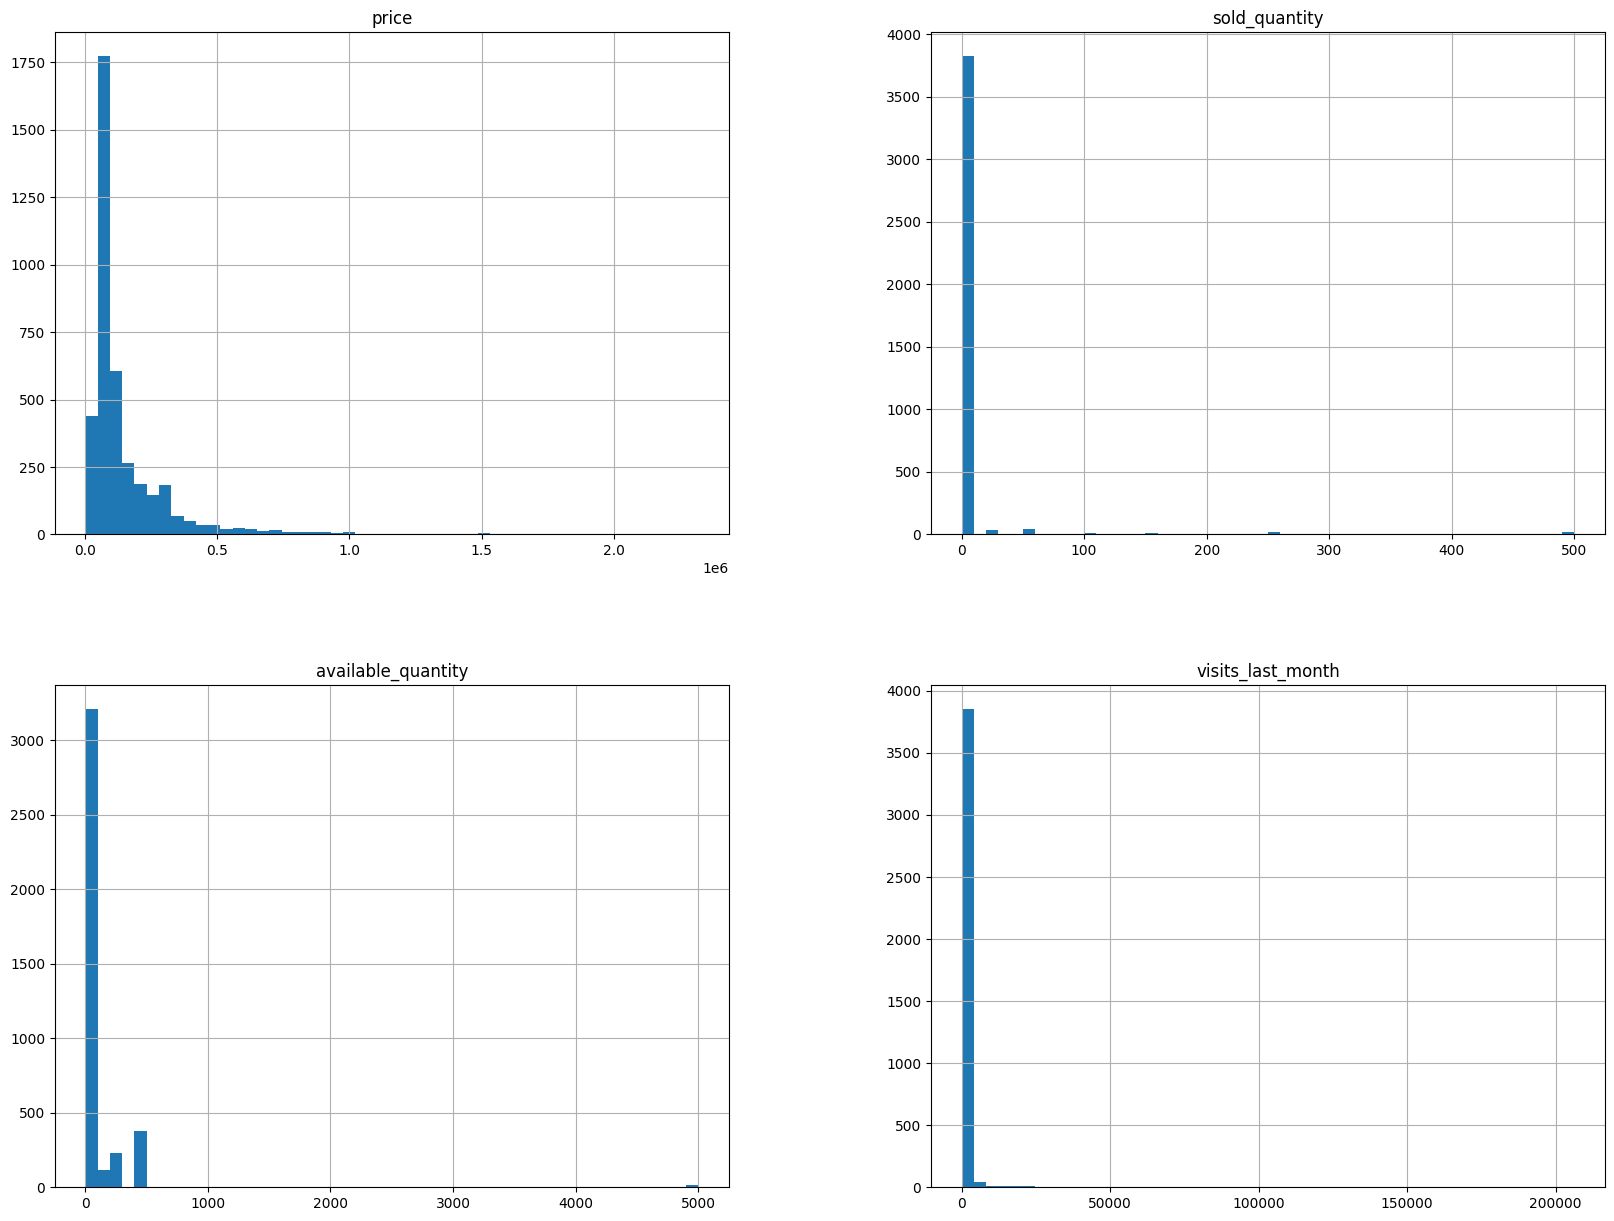

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
tablets.hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
a, _, _ = get_tokens()
a

'APP_USR-5030313997317379-062921-d22f0e23d59e60eecd8214f0f58b7698-675440595'

In [29]:
tablets["sold_quantity"].value_counts()

sold_quantity
5      91
50     34
0      27
25     25
1      23
2      21
250    18
500    15
3      14
4      11
150     9
100     8
200     2
Name: count, dtype: int64

In [14]:
print(date.today().isoformat())

2023-06-29


In [46]:
count_values = tablets["visits_last_month"].value_counts().sort_index()
sorted_values = count_values.sort_index()
print(sorted_values)

visits_last_month
0         870
1         321
2         177
3         150
4         150
         ... 
47280       1
50286       1
55971       1
75967       1
206292      1
Name: count, Length: 742, dtype: int64


In [37]:
tablets_int = tablets.select_dtypes(include='int64')
corr_matrix = tablets_int.corr()

In [38]:
corr_matrix["visits_last_month"].sort_values(ascending=False)

visits_last_month     1.000000
sold_quantity         0.654341
price                 0.001933
available_quantity   -0.010862
Name: visits_last_month, dtype: float64